In [ ]:
# !cp /content/drive/MyDrive/tobacco_yolo_format.zip /content/tobacco_yolo_format.zip
!cp /content/drive/MyDrive/Tobacc800_Groundtruth_v2.0.zip /content/Tobacc800_Groundtruth_v2.0.zip
!cp /content/drive/MyDrive/Tobacco800_SinglePage.zip /content/Tobacco800_SinglePage.zip
# !unzip /content/tobacco_yolo_format.zip 
!unzip /content/Tobacc800_Groundtruth_v2.0.zip
!unzip /content/Tobacco800_SinglePage.zip

In [ ]:
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
!sed -i 's/PyYAML>=5.3.1/PyYAML==5.4.1/g' /content/yolov5/requirements.txt
!pip install -qr '/content/yolov5/requirements.txt'

Cloning into 'yolov5'...
remote: Enumerating objects: 11242, done.
remote: Total 11242 (delta 0), reused 0 (delta 0), pack-reused 11242
Receiving objects: 100% (11242/11242), 11.14 MiB | 30.41 MiB/s, done.
Resolving deltas: 100% (7776/7776), done.
     |████████████████████████████████| 636 kB 5.2 MB/s 


# Convert Data

In [ ]:
df = []
cnt = 0

# refer the xml files to understand its structure and revist this code block.
annotations = sorted(glob('/content/Tobacc800_Groundtruth_v2.0/XMLGroundtruth_v2.0/*.xml'))
for file in annotations:
    myroot = ET.parse(file).getroot()
    # image filename is changed aah97e00-page02_1.tif -> 0.tif, so the previous filename is collected here.
    prev_filename = myroot[0].attrib['src']
    filename = str(cnt) + '.tif' # new filename based on the count (0.tif, 1.tif etc)
    page_height, page_width =  myroot[0][0].attrib['height'], myroot[0][0].attrib['width']
    
    row = []
    # An image might have multiple items (zones) (logos and signs), so iterate through each zones
    for zone in myroot[0][0]:
        category = zone.attrib['gedi_type'] # type of zone (DLLogo/ DLSignature)
        id = zone.attrib['id']
        x, y = zone.attrib['col'], zone.attrib['row'] # x, y coordinate
        w, h = zone.attrib['width'], zone.attrib['height'] # width and height of bbox
        
        # Signature have Authors, represeting whose signature it is
        if category == 'DLSignature':
            AuthorID = zone.attrib['AuthorID']
            Overlapped = zone.attrib['Overlapped']
            row = [prev_filename, filename, page_height, page_width, AuthorID, Overlapped, category, id, x, y, w, h]
            df.append(row)
#        #else:
            # Logos don't have authors.
#        #    AuthorID, Overlapped = ('NA', 'NA')
#        row = [prev_filename, filename, page_height, page_width, AuthorID, Overlapped, category, id, x, y, w, h]
#        df.append(row)
    cnt += 1

In [ ]:
data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'page_height', 'page_width', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height'])

In [ ]:
data

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height
0,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361
1,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183
2,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206
3,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110
4,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181
...,...,...,...,...,...,...,...,...,...,...,...,...
905,zrt45f00.tif,1283.tif,1575,1200,"Holek, M.L.",Yes,DLSignature,None,514,1019,278,48
906,zrz94a00-page02_2.tif,1285.tif,2156,1728,"Dimech, Ellen",Yes,DLSignature,None,828,1046,362,91
907,zss86d00.tif,1286.tif,2292,1728,"Nielsen, Vigo G.",Yes,DLSignature,None,867,1734,363,189
908,ztz52d00-page02_2.tif,1288.tif,2292,1728,"Bergman, J.I.",Yes,DLSignature,None,896,651,205,178


In [ ]:
test = data[['page_height', 'page_width']]
test.max(), test.min()

(page_height    3584
 page_width     2720
 dtype: object, page_height    1575
 page_width     1200
 dtype: object)

In [ ]:
BASE_DIR = '/content/Tobacco800_SinglePage/SinglePageTIF/'
SAVE_PATH = '/content/scaled/'
os.mkdir(SAVE_PATH)

def scale_image(df):
    df_new = []
    filename = df.prev_filename
    X, Y, W, H = map(int, df.x), map(int, df.y), map(int, df.width), map(int, df.height)
    for file, x, y, w, h in zip(filename, X, Y, W, H):
        image_path = BASE_DIR + file
        img = cv2.imread(image_path, 1)
        page_height, page_width = img.shape[:2]
        max_height = 640
        max_width = 480
        
        # computes the scaling factor
        if max_height < page_height or max_width < page_width:
            scaling_factor = max_height / float(page_height)
            if max_width/float(page_width) < scaling_factor:
                scaling_factor = max_width / float(page_width)
            # scale the image with the scaling factor
            img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
        jpg_filename = file[:-4] + '.jpg'
        new_file_path = SAVE_PATH + jpg_filename
        cv2.imwrite(new_file_path, img) # write the scales image
        
        # save new page height and width
        page_height, page_width = page_height*scaling_factor, page_width*scaling_factor
        # compute new x, y, w, h coordinates after scaling
        x, y, w, h= int(x*scaling_factor), int(y*scaling_factor), int(w*scaling_factor), int(h*scaling_factor)
        row = [jpg_filename, x, y, w, h, page_height, page_width]
        df_new.append(row)
    return df_new
scaled_data = scale_image(data)

In [ ]:
scaled_data = list(zip(*scaled_data))

data['new_filename'] = scaled_data[0]
data['x_scaled'] = scaled_data[1]
data['y_scaled'] = scaled_data[2]
data['w_scaled'] = scaled_data[3]
data['h_scaled'] = scaled_data[4]
data['page_height_scaled'] = scaled_data[5]
data['page_width_scaled'] = scaled_data[6]
data.head(10)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
1,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
2,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
3,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0
4,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636.666667,480.0
5,adh36e00-page2_2.tif,8.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1232,2399,896,431,adh36e00-page2_2.jpg,231,449,168,80,608.625000,480.0
6,adh36e00_2.tif,10.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1239,2403,889,434,adh36e00_2.jpg,232,450,166,81,608.625000,480.0
7,adn64a00-page02_3.tif,13.tif,2156,1728,"Koplow, M.G.",Yes,DLSignature,None,871,478,636,152,adn64a00-page02_3.jpg,241,132,176,42,598.888889,480.0
8,adp7aa00.tif,14.tif,3177,2544,"Lisanti, V.F.",No,DLSignature,None,257,2127,549,165,adp7aa00.jpg,48,401,103,31,599.433962,480.0
9,adq65f00.tif,15.tif,1575,1200,"Traviesas, H.",Yes,DLSignature,None,632,810,126,76,adq65f00.jpg,252,324,50,30,630.000000,480.0


In [ ]:
data

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
1,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
2,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
3,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0
4,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636.666667,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,zrt45f00.tif,1283.tif,1575,1200,"Holek, M.L.",Yes,DLSignature,None,514,1019,278,48,zrt45f00.jpg,205,407,111,19,630.000000,480.0
906,zrz94a00-page02_2.tif,1285.tif,2156,1728,"Dimech, Ellen",Yes,DLSignature,None,828,1046,362,91,zrz94a00-page02_2.jpg,230,290,100,25,598.888889,480.0
907,zss86d00.tif,1286.tif,2292,1728,"Nielsen, Vigo G.",Yes,DLSignature,None,867,1734,363,189,zss86d00.jpg,240,481,100,52,636.666667,480.0
908,ztz52d00-page02_2.tif,1288.tif,2292,1728,"Bergman, J.I.",Yes,DLSignature,None,896,651,205,178,ztz52d00-page02_2.jpg,248,180,56,49,636.666667,480.0


# Test Scaled Image

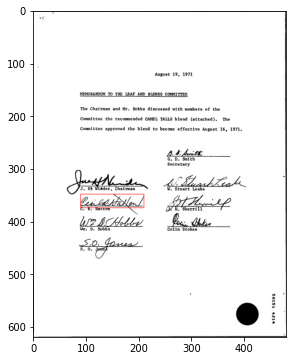

In [ ]:
img = cv2.imread('/content/scaled/agw39d00.jpg')

img = cv2.rectangle(img, (90, 348), (90+120, 348+26), (255, 0, 0), 1)
plt.figure(figsize=(6, 6))
plt.imshow(img)

# Save to csv

In [ ]:
data[['prev_filename', 'new_filename', 'filename', 'page_height', 'page_width', 'page_height_scaled', 'page_width_scaled', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height', 'x_scaled', 'y_scaled', 'w_scaled', 'h_scaled']].to_csv('/content/tobacco_cleaned.csv', index=False)
data.head(3)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
1,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
2,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0


# Convert Data to Yolo format

In [ ]:
def x_center(df):
  return int(df.x_scaled + (df.w_scaled/2))
def y_center(df):
  return int(df.y_scaled + (df.h_scaled/2))

def w_norm(df, col):
  return df[col]/df['page_width_scaled']
def h_norm(df, col):
  return df[col]/df['page_height_scaled']

df = pd.read_csv('/content/tobacco_cleaned.csv')

le = preprocessing.LabelEncoder()
le.fit(df['category'])
print(le.classes_)
labels = le.transform(df['category'])
df['labels'] = labels


df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df.apply(w_norm, col='x_center',axis=1)
df['width_norm'] = df.apply(w_norm, col='w_scaled', axis=1)

df['y_center_norm'] = df.apply(h_norm, col='y_center',axis=1)
df['height_norm'] = df.apply(h_norm, col='h_scaled',axis=1)

df.head(1)

['DLSignature']


,prev_filename,new_filename,filename,page_height,page_width,page_height_scaled,page_width_scaled,AuthorID,Overlapped,category,id,x,y,width,height,x_scaled,y_scaled,w_scaled,h_scaled,labels,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,aah97e00-page02_2.tif,aah97e00-page02_2.jpg,1.tif,3296,2560,618.0,480.0,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,264,148,123,67,0,325,181,0.677083,0.25625,0.29288,0.108414


In [ ]:
df_train, df_valid = model_selection.train_test_split(df, train_size = 0.54,test_size=0.36, shuffle=True)
print(df_train.shape, df_valid.shape)

(491, 26) (328, 26)


In [ ]:
!rm -r /content/tobacco_yolo_format

rm: cannot remove '/content/tobacco_yolo_format': No such file or directory


In [ ]:
os.mkdir('/content/tobacco_yolo_format/')
os.mkdir('/content/tobacco_yolo_format/images/')
os.mkdir('/content/tobacco_yolo_format/images/train/')
os.mkdir('/content/tobacco_yolo_format/images/valid/')

os.mkdir('/content/tobacco_yolo_format/labels/')
os.mkdir('/content/tobacco_yolo_format/labels/train/')
os.mkdir('/content/tobacco_yolo_format/labels/valid/')

## Segregating Data

In [ ]:
def segregate_data(df, img_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    #print(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.new_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.new_filename), os.path.join(train_img_path,row.new_filename))
 
# Apply function
src_img_path = "/content/scaled/"
src_label_path = "/content/groundtruth/"

train_img_path = "/content/tobacco_yolo_format/images/train"
train_label_path = "/content/tobacco_yolo_format/labels/train"

valid_img_path = "/content/tobacco_yolo_format/images/valid"
valid_label_path = "/content/tobacco_yolo_format/labels/valid"

segregate_data(df_train, src_img_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, valid_img_path, valid_label_path)

print("No. of Training images", len(os.listdir('/content/tobacco_yolo_format/images/train')))
print("No. of Training labels", len(os.listdir('/content/tobacco_yolo_format/labels/train')))

print("No. of valid images", len(os.listdir('/content/tobacco_yolo_format/images/valid')))
print("No. of valid labels", len(os.listdir('/content/tobacco_yolo_format/labels/valid')))

No. of Training images 446
No. of Training labels 446
No. of valid images 303
No. of valid labels 303


In [ ]:
print("No. of Training images", len(os.listdir('/content/yolov5/tobacco_yolo_format/images/train')))
print("No. of Training labels", len(os.listdir('/content/yolov5/tobacco_yolo_format/labels/train')))
print("No. of valid images", len(os.listdir('/content/yolov5/tobacco_yolo_format/images/valid')))
print("No. of valid labels", len(os.listdir('/content/yolov5/tobacco_yolo_format/labels/valid')))

FileNotFoundError: ignored

In [ ]:
# !zip /content/tobacco_yolo_format.zip /content/tobacco_yolo_format
# !cp /content/tobacco_yolo_format.zip /content/drive/MyDrive/

# Training

In [ ]:
!cp /content/drive/MyDrive/best_representativedata.pt /content/best_representativedata.pt

In [ ]:
!pip install wandb
import wandb
wandb.init()

In [ ]:
# Setting the model parameters
shutil.copyfile('/content/tobacco_data.yaml', '/content/yolov5/tobacco_data.yaml') # copying the custom_dataset.yaml file to the project repo
#setting number of classes to two (since the tobacco 800 dataset contains 2 classes, Logo & Signature)
!sed -i 's/nc: 80/nc: 2/g' /content/yolov5/models/yolov5x.yaml
!cat /content/yolov5/tobacco_data.yaml

train: masked/images/train
val: masked/images/valid

nc: 2
names: ['Checked', 'Not Checked']

In [ ]:
!nvidia-smi

Sun Feb 27 02:19:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python /content/yolov5/train.py --img 640 --batch 14 --epochs 50 \
    --data /content/yolov5/tobacco_data.yaml --cfg /content/yolov5/models/yolov5x.yaml --name checkbox --save-period 50 --bbox_interval 50 --upload_dataset 

In [ ]:
!python yolov5/detect.py --source "/content/data/signed_images_with_original_images" --img 640 --weights '/content/yolo_signature.pt' --line-thickness 2 

detect: weights=['/content/yolo_signature.pt'], source=/content/data/signed_images_with_original_images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-27-gb94b59e torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
image 1/1395 /content/data/signed_images_with_original_images/1.jpg: 288x640 1 DLSignature, Done. (0.028s)
image 2/1395 /content/data/signed_images_with_original_images/10.jpg: 320x640 Done. (0.025s)
image 3/1395 /content/data/signed_images_with_original_images/11.jpg: 256x640 2 DLSignatures, Done. (0.024s)
image 4/1395 

In [ ]:
from detect import run

run(
    weights = '/content/best_representativedata.pt',
    source = 'https://transaferimagestorage.blob.core.windows.net/randdimages/4UEnkm1r1641343043276.jpg'
)

  0%|          | 0.00/238k [00:00<?, ?B/s]

YOLOv5 🚀 v6.1-11-g63ddb6f torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 444 layers, 86173414 parameters, 0 gradients, 204.0 GFLOPs
image 1/1 /content/yolov5/4UEnkm1r1641343043276.jpg: 640x480 1 DLSignature, Done. (0.031s)
Speed: 0.6ms pre-process, 31.4ms inference, 1.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp6


In [ ]:
!unzip /content/data.zip

In [ ]:
# !python /content/yolov5/train.py --img 640 --batch 14 --epochs 3000 \
#     --data /content/yolov5/tobacco_data.yaml --cfg /content/yolov5/models/yolov5x.yaml --name Tobacco-run2 --save-period 50 --bbox_interval 50 --upload_dataset \
#     --weights /content/yolov5/runs/train/Tobacco-run/weights/best.pt

In [ ]:
!zip -r /content/train_v2.zip /content/yolov5/runs/train

In [ ]:
!cp /content/drive/MyDrive/data.zip /content/data.zip